In [1]:
import torch
from binNF.normalizing_flows.manager import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import torch.multiprocessing as mp
from mpl_toolkits.mplot3d import Axes3D
import vegas
import time
import datetime

In [2]:
def step(x):
    a=torch.zeros_like(x[:,0])
    b=torch.ones_like(x[:,0])
   
    return torch.where(torch.max(abs(x[:,0]), abs(x[:,1]))>1,a,b)

def g(x): #box: expect 0.25 in dim2
   
    q=torch.max(torch.abs(x),dim=-1).values
  
    a=torch.zeros_like(q)
    b=torch.ones_like(q)
   
    return torch.where(q<0.5,a,b)

def gaussian(x):
    return torch.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2)) 

def gaussiannp(x):
    return np.exp( -((x[:,0]-0.5)**2+(x[:,1]-0.5)**2)/(0.3**2))

def gaussianveg(x):
    return np.exp( -((x[0]-0.5)**2+(x[1]-0.5)**2)/(0.3**2))


def camelnp(x):
    return np.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+np.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def camelveg(x):
    return np.exp( -((x[0]-0.75)**2+(x[1]-0.75)**2)/(0.2**2))+np.exp( -((x[0]-0.25)**2+(x[1]-0.25)**2)/(0.2**2))


def camel(x):
    return torch.exp( -((x[:,0]-0.75)**2+(x[:,1]-0.75)**2)/(0.2**2))+torch.exp( -((x[:,0]-0.25)**2+(x[:,1]-0.25)**2)/(0.2**2))

def gaussianb(x):
    return torch.exp( -(x)**2)[:,0]

def gaussianbnp(x):
    return np.exp( -((x[:,0]+1)**2+(x[:,1])**2) )



def con(x):
    y=torch.empty(x.shape[0])
    return y.fill_(5)

def sin(x):
    return 2+torch.sin(x[:,1])

def lin(x):
    return 0.2*x[:,0]+0.5

def sinnp(x):
    return 2+np.sin(x[:,1])

def tanp(r):
    return (1+((torch.tan((r-0.5)*np.pi))**2))*np.pi

def vegastest(x):
    gw=0.2
    shift=np.ones_like(x)*0.25
    shift1=shift.copy()*3
    lim=int((shift.shape[1]/2))
    shift2=np.concatenate((shift[:,:lim],shift1[:,lim:]),-1)
    shift3=np.concatenate((shift1[:,:lim],shift[:,lim:]),-1)
    return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))



def create_fun(gn, gw):
    
    if(gn==1):
        def f(x):
                return torch.exp(-torch.sum((x-0.5)**2/(gw**2),-1))
        return f
    
    if(gn==2):
        def f(x):
                return torch.exp(-torch.sum((x-0.25)**2/(gw**2),-1))+torch.exp(-torch.sum((x-0.75)**2/(gw**2),-1))
        return f
    
    if(gn==4):
        def f(x):
            shift=torch.ones_like(x)*0.25
            shift1=shift.clone()*3
            lim=int((shift.shape[1]/2))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:]),-1)
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))
        return f
    
    if(gn==8):
        def f(x):
            shift=torch.ones_like(x)*0.25#000
            shift1=shift.clone()*3#111
            lim=int((shift.shape[1]/3))
            shift2=torch.cat((shift[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #010
            shift3=torch.cat((shift1[:,:lim],shift[:,lim:]),-1)#100
            shift4=torch.cat((shift1[:,:lim],shift1[:,lim:2*lim],shift[:,2*lim:]),-1) #110
            shift5=torch.cat((shift[:,:2*lim],shift1[:,2*lim:]),-1) #001
            shift6=torch.cat((shift1[:,:lim],shift[:,lim:2*lim],shift1[:,2*lim:]),-1) #101
            shift7=torch.cat((shift[:,:lim],shift1[:,lim:]),-1) #011
            return torch.exp(-torch.sum((x-shift)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift1)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift2)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift3)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift4)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift5)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift6)**2/(gw**2),-1))+torch.exp(-torch.sum((x-shift7)**2/(gw**2),-1))
        return f
    
def create_funv(gn, gw):
    
    if(gn==1):
        def f(x):
                return np.exp(-np.sum((x-0.5)**2/(gw**2),-1))
        return f # peak at [0.5,...,0.5]
    
    if(gn==2):
        def f(x):
                return np.exp(-np.sum((x-0.25)**2/(gw**2),-1))+np.exp(-np.sum((x-0.75)**2/(gw**2),-1))
        return f  #peak at [0.25,...,0.25] and [0.75,...,0.75]
    
    if(gn==4):
        
        def f(x):
            shift=np.ones_like(x)*0.25
            shift1=shift.copy()*3
            lim=int((shift.shape[0]/2))
            shift2=np.concatenate((shift[:lim],shift1[lim:]),-1)
            shift3=np.concatenate((shift1[:lim],shift[lim:]),-1)
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))
        return f #peak at [0.25,...,0.25], [0.75,...,0.75],[0.25,...,0.75], [0.25,...,0.75]
                #in dim2, there would be in the [0,1] plane only two peaks, as two are identical
                # other than gn=2, the [1,2] plane has 4 peaks
              
    
    if(gn==8):
        
        def f(x):
            shift=np.ones_like(x)*0.25#000
            shift1=shift.copy()*3#111
            lim=int(shift.shape[0]/3)
            shift2=np.concatenate((shift[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #010
            shift3=np.concatenate((shift1[:lim],shift[lim:]),0)#100
            shift4=np.concatenate((shift1[:lim],shift1[lim:2*lim],shift[2*lim:]),0) #110
            shift5=np.concatenate((shift[:2*lim],shift1[2*lim:]),0) #001
            shift6=np.concatenate((shift1[:lim],shift[lim:2*lim],shift1[2*lim:]),0) #101
            shift7=np.concatenate((shift[:lim],shift1[lim:]),0) #011
            return np.exp(-np.sum((x-shift)**2/(gw**2),-1))+np.exp(-np.sum((x-shift1)**2/(gw**2),-1))+np.exp(-np.sum((x-shift2)**2/(gw**2),-1))+np.exp(-np.sum((x-shift3)**2/(gw**2),-1))+ np.exp(-np.sum((x-shift4)**2/(gw**2),-1))+np.exp(-np.sum((x-shift5)**2/(gw**2),-1))+np.exp(-np.sum((x-shift6)**2/(gw**2),-1))+np.exp(-np.sum((x-shift7)**2/(gw**2),-1))
        return f #here, in [0,1] plane there are actually 4 peaks

In [11]:
n_flow = 9# number of dimensions

 
# We define our NormalizingFlow object 
NF =  PWQuadManager(n_flow=n_flow)



In [12]:

#The model is created
NF.create_model(n_cells=8, n_bins=7, NN=[11,11,11,11,11],dev=torch.device("cpu")) 
optim = torch.optim.Adamax(NF._model.parameters(),lr=2e-3, weight_decay=5e-07) 



"""
w = torch.empty(10, NF.n_flow)
torch.nn.init.uniform_(w)
XJ = NF.model(NF.format_input(w,dev=torch.device("cpu")))
X = (XJ[:, :-1])
f=create_fun(1,0.2)
#print(w)
print(X)
print(camel(X))
print(f(X))
"""

'\nw = torch.empty(10, NF.n_flow)\ntorch.nn.init.uniform_(w)\nXJ = NF.model(NF.format_input(w,dev=torch.device("cpu")))\nX = (XJ[:, :-1])\nf=create_fun(1,0.2)\n#print(w)\nprint(X)\nprint(camel(X))\nprint(f(X))\n'

In [14]:
start_time=datetime.datetime.utcnow()
history=NF._train_variance_forward_seq(create_fun(1,0.22),optim,"./logs/tmp/",120000,1000,0,True, True,True)
end_time=datetime.datetime.utcnow()
print((end_time-start_time).total_seconds())

#CLEAN UP AND GIT
#FULL TEST 32
#CHECK BOUNDARY
#SEND OUT CALCULATION



#with preburner: dim 9 stable and reduction, but result looks still a bit weird, but 4 looks a bit weird too but ok

#status: we seem to have now a stable algorithm with a certain improvement, however it is not sure 
#how well it does recognise the peaks. maybe looking for recognition is the wrong approach
#also it runs kinda long; stale killer could be broken

#test output of exp_single in graphics, start mfrun
#n=16 does not look good but has low loss..I don't get it...I think the images make no sense anymore
#in higher dimensions, only the loss counts and it should be stable. 


KeyboardInterrupt: 

In [6]:

print('Initial loss')
print(NF.int_loss)
print('Epoch of best result')
print(NF.best_epoch)
print('Best loss')
print(NF.best_loss)
print('Best loss relative')
print(NF.best_loss_rel)
print('Function evaluations')
print(NF.best_func_count)
print('loss_estimator_var')
print(NF.best_var) 
w = torch.empty(10000, NF.n_flow)
torch.nn.init.uniform_(w)
#initial_loss_test=torch.mean()


Initial loss
tensor(3.3677e-11)
Epoch of best result
67
Best loss
tensor(2.0946e-11, grad_fn=<DivBackward0>)
Best loss relative
tensor(0.6220, grad_fn=<DivBackward0>)
Function evaluations
8180000
loss_estimator_var
1.4477057066589098e-21


tensor([[0.8593, 0.6713, 0.2238,  ..., 0.5544, 0.7277, 0.6269],
        [0.4739, 0.9244, 0.4058,  ..., 0.2956, 0.0116, 0.0708],
        [0.8759, 0.7810, 0.0643,  ..., 0.2028, 0.9024, 0.7304],
        ...,
        [0.8155, 0.3374, 0.5100,  ..., 0.5906, 0.7918, 0.5911],
        [0.0142, 0.5359, 0.3927,  ..., 0.2812, 0.9527, 0.1884],
        [0.1214, 0.2196, 0.0345,  ..., 0.6888, 0.7224, 0.1956]])

In [7]:

w = torch.empty(40, NF.n_flow)
torch.nn.init.uniform_(w)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w,torch.device("cpu")))

#print("mapped")
#print(NF.format_input(100*torch.tan((w-0.5)*(np.pi))))
XJ=NF.model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian

XJ2=NF.best_model(NF.format_input(w,torch.device("cpu")))


                    # Separate the points and their Jacobians:
print("XJ2")
print(XJ2)

"""
f=gaussian
print("f(x)")
print(f(X))


print("fXJ")
print(torch.mul(f(X), XJ[:, -1]))

print("loss without jac")
print(torch.mean(f(X)**2))

print("squared mean")
print(torch.mean(f(X))**2)

print("loss")
print(torch.mean(torch.mul(f(X), XJ[:, -1])**2))

"""

W
tensor([[0.2931, 0.7449, 0.8323, 0.7003, 0.3071, 0.1219, 0.2894, 0.9244, 0.8527],
        [0.4333, 0.1965, 0.9032, 0.2409, 0.1440, 0.4739, 0.5636, 0.1243, 0.5291],
        [0.1303, 0.8211, 0.6097, 0.6419, 0.7656, 0.6715, 0.0108, 0.4581, 0.3620],
        [0.4766, 0.7157, 0.9947, 0.6680, 0.7590, 0.6508, 0.8921, 0.6058, 0.5823],
        [0.5622, 0.0626, 0.7437, 0.7558, 0.9818, 0.7471, 0.7714, 0.1849, 0.2349],
        [0.2690, 0.8410, 0.0729, 0.2485, 0.8698, 0.2793, 0.1064, 0.0060, 0.2264],
        [0.6164, 0.6616, 0.2897, 0.0160, 0.9148, 0.0022, 0.9536, 0.0840, 0.8905],
        [0.5277, 0.1665, 0.6026, 0.5618, 0.3413, 0.9046, 0.1694, 0.7730, 0.5470],
        [0.8825, 0.5861, 0.9350, 0.4255, 0.7467, 0.8497, 0.1334, 0.5523, 0.4185],
        [0.4842, 0.5534, 0.7410, 0.3538, 0.9901, 0.7748, 0.3847, 0.8891, 0.1119],
        [0.5528, 0.7076, 0.4874, 0.4157, 0.6560, 0.5817, 0.8930, 0.7854, 0.4224],
        [0.8882, 0.7056, 0.0803, 0.9057, 0.0262, 0.1869, 0.5035, 0.4140, 0.6619],
        [0.410

XJ2
tensor([[4.8908e-01, 6.3781e-01, 6.2224e-01, 6.9201e-01, 3.2747e-01, 8.4170e-02,
         3.4525e-01, 6.9613e-01, 9.4990e-01, 1.5098e-02],
        [5.6742e-01, 5.1523e-01, 8.9545e-01, 2.1138e-01, 1.1966e-01, 4.8335e-01,
         5.3712e-01, 1.2358e-01, 5.3780e-01, 3.1057e-01],
        [2.5841e-01, 6.5502e-01, 5.9233e-01, 6.3695e-01, 6.5772e-01, 6.2427e-01,
         8.6236e-04, 6.5055e-01, 4.4882e-01, 2.4836e-02],
        [6.2051e-01, 7.5936e-01, 9.9656e-01, 5.0932e-01, 6.5526e-01, 5.2718e-01,
         9.4306e-01, 6.7143e-01, 5.3193e-01, 1.3823e-03],
        [6.7757e-01, 8.6608e-02, 7.4691e-01, 7.7894e-01, 9.7004e-01, 6.1295e-01,
         7.4405e-01, 1.7432e-01, 1.7115e-01, 1.8621e-01],
        [1.7050e-01, 6.8801e-01, 1.2990e-01, 3.7269e-01, 6.9404e-01, 1.8298e-01,
         3.9512e-02, 3.1459e-02, 2.8821e-01, 1.5669e-01],
        [5.6482e-01, 3.7477e-01, 3.6682e-01, 1.0667e-02, 7.8485e-01, 3.1442e-03,
         9.7635e-01, 1.6374e-01, 8.7926e-01, 1.3072e+00],
        [5.0032e-01, 2.

'\nf=gaussian\nprint("f(x)")\nprint(f(X))\n\n\nprint("fXJ")\nprint(torch.mul(f(X), XJ[:, -1]))\n\nprint("loss without jac")\nprint(torch.mean(f(X)**2))\n\nprint("squared mean")\nprint(torch.mean(f(X))**2)\n\nprint("loss")\nprint(torch.mean(torch.mul(f(X), XJ[:, -1])**2))\n\n'

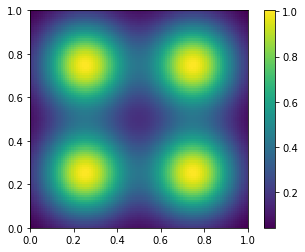

In [41]:
xs = np.linspace(-0,1,100)
ys = np.linspace(1,0,100) # in images the y axis is inverted
Xs,Ys = np.meshgrid(xs,ys)
zs=vegastest(np.array(list(zip(Xs.reshape(100*100),Ys.reshape(100*100)))).astype(np.float32)).reshape(100,100)

plt.imshow(zs, extent=[0,1,0,1])

plt.colorbar()
plt.show()

In [22]:
print("reset")
NF.create_model(n_pass_through=1,n_cells=1,n_bins=10, nn_width=2, NN=[20,20,20], roll_step=0)

w = torch.empty(10000, NF.n_flow, requires_grad=True)
torch.nn.init.uniform_(w,0,1)

print("W")
print(w)
                    #print(self.format_input(w).requires_grad)
print("with jacob")                  # Output a sample of (phase-space point, forward Jacobian)
print(NF.format_input(w))
XJ = NF.model(NF.format_input(w))

                    # Separate the points and their Jacobians:
print("XJ")
print(XJ)# This sample is fixed, we optimize the Jacobian
X = ((XJ[:, :-1]).detach())
print("X")
print(X)
print("diff")
print(X[:,0]-w[:,1])
print("f(x)")
print(sin(X))

print("fXJ")
print(torch.mul(sin(X), XJ[:, -1]))

reset
W
tensor([[0.6108, 0.7451],
        [0.3028, 0.2412],
        [0.2823, 0.1151],
        ...,
        [0.5725, 0.1838],
        [0.8225, 0.9309],
        [0.1988, 0.2423]], requires_grad=True)
with jacob
tensor([[0.6108, 0.7451, 1.0000],
        [0.3028, 0.2412, 1.0000],
        [0.2823, 0.1151, 1.0000],
        ...,
        [0.5725, 0.1838, 1.0000],
        [0.8225, 0.9309, 1.0000],
        [0.1988, 0.2423, 1.0000]], grad_fn=<CatBackward>)
XJ
tensor([[0.6108, 0.7238, 0.7407],
        [0.3028, 0.2571, 1.1249],
        [0.2823, 0.1301, 1.1378],
        ...,
        [0.5725, 0.1827, 1.4329],
        [0.8225, 0.9263, 1.0666],
        [0.1988, 0.2883, 0.6346]], grad_fn=<CatBackward>)
X
tensor([[0.6108, 0.7238],
        [0.3028, 0.2571],
        [0.2823, 0.1301],
        ...,
        [0.5725, 0.1827],
        [0.8225, 0.9263],
        [0.1988, 0.2883]])
diff
tensor([-0.1342,  0.0616,  0.1672,  ...,  0.3886, -0.1084, -0.0435],
       grad_fn=<SubBackward0>)
f(x)
tensor([2.6622, 2.2543, 

In [ ]:
"""
#a4=fig.add_subplot(143)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax.title.set_text('Jacobian after training')
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


NF.create_model(n_pass_through=1,n_cells=1, nn_width=2, NN=[5], roll_step=1)
rcParams['axes.labelpad'] = 800
z = torch.empty((10000,2)) 
torch.nn.init.uniform_(z,0,1)

w=NF.format_input(z)
X=NF.model(w).data.numpy()
fig = plt.figure()
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter3D(X[:,0],X[:,1],X[:,2])
#plt.2d(X[:,0],X[:,1],X[:,2])
#ax.set_aspect(aspect=1.)
ax1.title.set_text('Jacobian before training')
ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)
#ax1.auto_scale_xyz([0.5, 2], [0, 1], [1.55, 1.75])
ax1.xaxis._axinfo['label']['space_factor'] = 4.8
ax1.zaxis._axinfo['label']['space_factor'] = 8.8
rcParams['axes.labelpad'] = 80

print("\n")
"""

RuntimeError: running_mean should contain 1 elements not 8

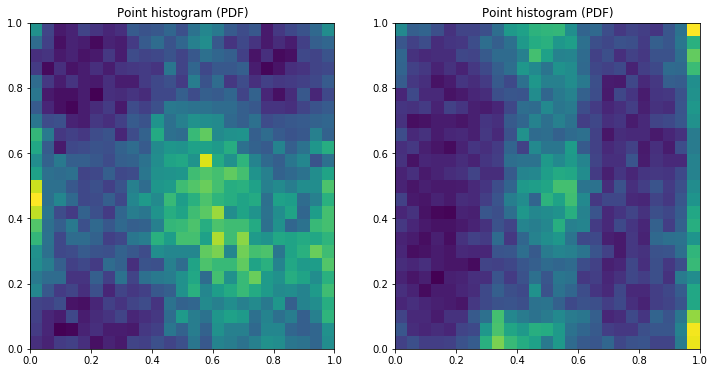

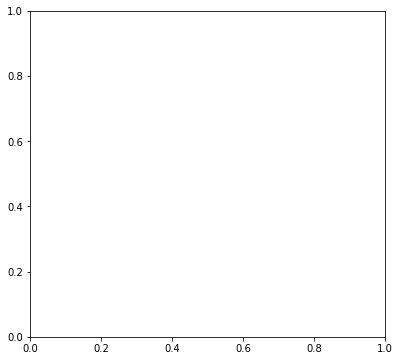

In [13]:
n_flow=9
w = torch.empty((20000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
#q = torch.empty((12100,2)) 
#torch.nn.init.normal_(q,std=10)
#z=150*torch.tan((w-0.5)*(np.pi))
#model=torch.load('/home/niklas/Desktop/Thesis_code/Storage_runs/2805_single/torch',map_location=torch.device('cpu'))
#NF.best_model.load_state_dict(model['model_state_dict'])
#model=NF.best_model
Y=NF.format_input(w, dev=torch.device("cpu"))
X=NF.model(Y)
XZ=NF.best_model(Y)
#Z=(torch.atan(X)/np.pi+0.5).data.numpy()
#print(Z)
X=X.data.numpy()
XX=XZ.data.numpy()
#z=z.data.numpy()
#a3=fig.add_subplot(133)
fig = plt.figure(figsize=(12, 6))
a3=fig.add_subplot(121)

plt.hist2d(XX[:,0],XX[:,1],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1]) 
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a3.title.set_text('Point histogram (PDF)')
a3.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)


#fig = plt.figure(figsize=(6, 6))
a4=fig.add_subplot(122)

plt.hist2d(XX[:,2],XX[:,3],bins=25)
axes = plt.gca()
axes.set_xlim([-0,1])
axes.set_ylim([-0,1])
#a3.set_aspect(aspect=1.)


a4.title.set_text('Point histogram (PDF)')
a4.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    left=True,         # ticks along the top edge are off
    labelbottom=True,
    labelleft=True)

f=camel

fig = plt.figure(figsize=(14, 6))
a5=fig.add_subplot(121)

#print(NF.model)

w = torch.empty((1000,n_flow)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            Z=m[1].NN(w[:,:1])
            
            W=Z[:,:,m[1].n_bins+1:]
           
            W=torch.exp(W)
        
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            #print(w)
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
           
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            
            coords=np.stack([w[:,0].numpy() for 
                             _ in range(m[1].n_bins)], axis=0).reshape(w.shape[0]*m[1].n_bins,-1)
            
                
            
            
            plt.scatter(coords,torch.squeeze(Wsum,-1).detach().numpy(),c=torch.squeeze(VW,-1).detach().numpy())
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
      
        
        if(m[0]=='1'):
            a6=fig.add_subplot(122)
            
        
            Z=m[1].NN(torch.unsqueeze(w2[:,1],-1))
            
            W=Z[:,:,m[1].n_bins+1:]
            W=torch.exp(W)
            w2=w2.detach()
            Wsum = torch.cumsum(W, axis=-1) 
        
            Wnorms = torch.unsqueeze(Wsum[:, :, -1], axis=-1) 
            
            
            W = W/Wnorms
            Wsum=Wsum/Wnorms
            
            Wsum=torch.transpose(Wsum,0,2).reshape(m[1].n_bins*w2.shape[0],1,-1)
            V=Z[:,:,:m[1].n_bins+1]
            V=torch.exp(V)
        
            Vsum=torch.cumsum(V, axis=-1)


            Vnorms=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)

            Vnorms_tot=Vnorms[:, :, -1].clone() 
            V=torch.div(V,torch.unsqueeze(Vnorms_tot,axis=-1)) 
            VW=torch.cumsum(torch.mul((V[:,:,:-1]+V[:,:,1:])/2,W),axis=-1)
            VW=torch.transpose(VW,0,2).reshape(m[1].n_bins*w.shape[0],1,-1)
            
            coords=np.stack([w2[:,1].numpy() for _ in range(m[1].n_bins)], axis=0)  
            
            plt.scatter(torch.squeeze(Wsum,-1).detach().numpy(), coords, c=torch.squeeze(VW,-1).detach().numpy())

plt.colorbar()


fig = plt.figure(figsize=(14, 6))
a7=fig.add_subplot(121)

w = torch.empty((10000,2)) 
torch.nn.init.uniform_(w,0,1)
for idx, m in enumerate(NF.model.named_children()):
        if(m[0]=='0'):
            
           
            
            plt.scatter(torch.unsqueeze(w[:,0],-1).detach().numpy(),torch.unsqueeze(w[:,1],-1).detach().numpy(),
                                c=torch.unsqueeze(m[1](NF.format_input(w,torch.device("cpu")))[:,1],-1).detach().numpy(),cmap='jet')
            
            w2=m[1](NF.format_input(w,torch.device("cpu")))
            w2=torch.cat((torch.roll(w2[:, :-1], 1, dims=-1), w2[:, -1:]), axis=-1)
        
        if(m[0]=='1'):
            a8=fig.add_subplot(122)
            q=m[1](NF.format_input(w2,torch.device("cpu")))
            c=torch.cat((torch.roll(q[:, :-1], 1, dims=-1), q[:, -1:]), axis=-1)
        
            plt.scatter(torch.unsqueeze(w2[:,1],-1).detach().numpy(),torch.unsqueeze(w2[:,0],-1).detach().numpy(),
                                c=torch.unsqueeze(q[:,1],-1).detach().numpy(),cmap='jet')
plt.colorbar()


In [4]:
w = torch.empty(20, 2)
torch.nn.init.normal_(w, std=100)
w.device

device(type='cpu')

In [25]:
f=camel
w = torch.empty(80000, NF.n_flow)
torch.nn.init.uniform_(w)
XJ = NF.best_model(NF.format_input(w,dev=torch.device("cpu")))
X = (XJ[:, :-1])
fXJ = torch.mul(f(X), XJ[:, -1])
loss = torch.mean(fXJ**2)
print(loss)
#0.083+-0.004

tensor(0.0782, grad_fn=<MeanBackward0>)


In [53]:
"""
integ = vegas.Integrator([[0, 1], [0, 1]])

result = integ(camelveg, nitn=10, neval=1000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
"""
ngrid=40
f=create_funv(8,0.1)
#f=camelveg
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*4, ninc=ngrid)


ny = np.int(30000*np.sqrt(2))
y = np.random.uniform(0., 1., (ny, 4))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)
#print('intial grid:')
#print(m.settings(ngrid))

for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    #print('iteration %d:' % itn)
    #print(m.settings(ngrid))
    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()


m.show_grid(ngrid,[[0,1]])
#m.show_grid(ngrid, [[0,2]])
#m.show_grid(ngrid,[[0,3]])
#m.show_grid(ngrid,[[1,2]])
#m.show_grid(ngrid,[[1,3]])
#m.show_grid(ngrid,[[2,3]])
lossrel=loss/loss_int
print("LOSSREL")
print(lossrel)
print("Time")
print((end_time-start_time).total_seconds())
print("loss")
print(loss)

0.0019022155244321941
0.0019022155244322264


KeyboardInterrupt: 

[[0, 1], [0, 1]]


tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]], dtype=torch.int32)
tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=torch.int32)
tensor([[ 4],
        [ 5],
        [ 6],
        [ 7],
        [12],
        [13],
        [14],
        [15]])


TypeError: new(): data must be a sequence (got float)

OSError: [Errno 12] Cannot allocate memory

0.00011138330464215584
0.00011138330464215985
5.355396944289663e-05
4.333395373713114e-05
3.979782268664108e-05
3.83407964562675e-05
3.762991247963895e-05
3.720657598439942e-05
3.691243239660319e-05
3.6691151554065106e-05
3.651742246253374e-05
0.3265995103253669


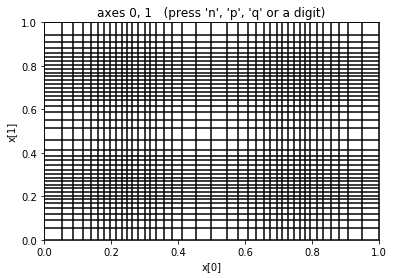

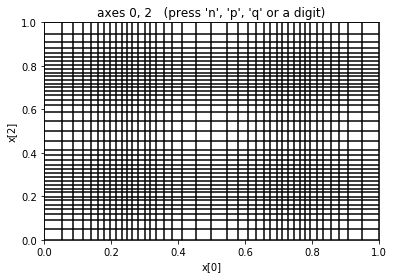

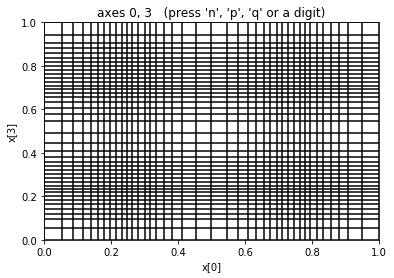

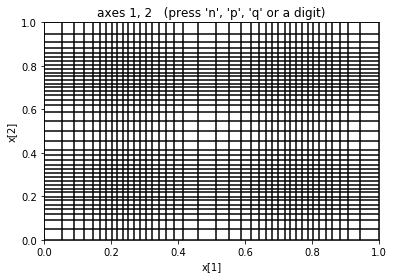

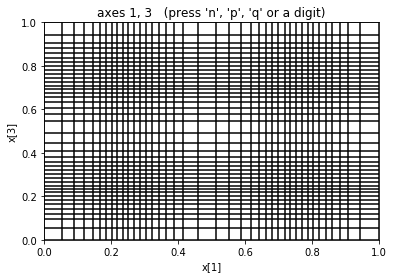

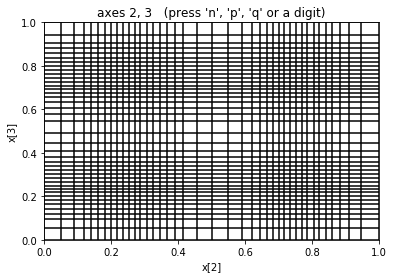

In [11]:
#test also dim=3
n_flow=8
ngrid=40
f=create_funv(8,0.2)
#f=camelveg
start_time=datetime.datetime.utcnow()
m = vegas.AdaptiveMap([[0, 1]]*n_flow, ninc=ngrid)

#m.show_grid(ngrid,axes=[[2,1],[0,2],[0,3],[1,2],[1,3],[2,3]])
#we gave NIS 3 000 000 evaluations -> 10 iterations * 300000 y's  ... 5 iterations till adaption
ny = np.int(30000*np.sqrt(4))
y = np.random.uniform(0., 1., (ny, n_flow))  # 300 000 random y's

x = np.empty(y.shape, float)            # work space
jac = np.empty(y.shape[0], float)
f2 = np.empty(y.shape[0], float)
loss_int=0
for j in range(ny): 
    loss_int+=f(y[j])**2/ny
print(loss_int)
#print('intial grid:')
#print(m.settings(ngrid))

for itn in range(10):                    # 10 iterations to adapt
    m.map(y, x, jac)                     # compute x's and jac
    loss=0
    for j in range(ny):                  # compute training data
        f2[j] = (jac[j] * f(x[j])) ** 2

    loss=np.mean(f2)
    print(loss)
    m.add_training_data(y, f2)           # adapt
    m.adapt(alpha=1)

    #print('iteration %d:' % itn)
    #print(m.settings(ngrid))
    

m.map(y, x, jac)                     # compute x's and jac
loss=0
for j in range(ny):                  # compute training data
    f2[j] = (jac[j] * f(x[j])) ** 2

loss=np.mean(f2)
end_time=datetime.datetime.utcnow()
print(loss/loss_int)

m.show_grid(ngrid,[[0,1]])
m.show_grid(ngrid, [[0,2]])
m.show_grid(ngrid,[[0,3]])
m.show_grid(ngrid,[[1,2]])
m.show_grid(ngrid,[[1,3]])
m.show_grid(ngrid,[[2,3]])
#dim 16
#1.3e-4
#5e-5->sees only one peak
#2e-5->sees only one peak
#1.1 e-4->sees only one peak
#In dim 16, it is cheaper to omit a peak than to create additional peaks
#this reduces the penalty considerably


tensor([7.5306e-12, 1.9125e-05, 2.6957e-12, 4.1090e-09, 1.6214e-10])
tensor([7.5476e-12, 1.9127e-05, 3.1358e-10, 4.1266e-09, 6.1647e-08])
tensor([5.4660e-10, 1.2383e-03, 3.8232e-10, 3.7878e-04, 1.0395e-07])
7.530609e-12
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.25 0.25 0.25 0.25 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.25 0.25 0.25 0.25]
7.547541e-12
5.4660076e-10
